# Home Credit Default Risk

- Goals: 
- Objectives: Membuat model machine learning yang dapat memprediksi apakah user yang akan mengajukan kredit dapat membayar tepat waktu atau akan bermasalah.
- Metrics: ROC-AUC (Minimal 60%)

**Library**

In [50]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 100)

### **1. Load Dataset**

#### **Data Training**

In [2]:
app_train = pd.read_csv('application_train.csv')
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [3]:
# jumlah baris dan kolom pada data train
app_train.shape

(307511, 122)

In [4]:
# jumlah nilai unik pada kolom SK_ID_CURR
app_train['SK_ID_CURR'].nunique()

307511

Tidak ada data duplikat pada kolom SK_ID_CURR

In [5]:
# jumlah kemunculan setiap nilai unik pada kolom Target
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

Data training memiliki 307511 baris dan 122 kolom termasuk kolom Target (label yang akan diprediksi)

#### **Data Testing**

In [6]:
app_test = pd.read_csv('application_test.csv')
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,...,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,...,0.3081,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.375,0.0417,0.2078,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0

In [7]:
# jumlah baris dan kolom pada data train
app_test.shape

(48744, 121)

Data Testing jauh lebih kecil dari Data Training dan tidak memiliki kolom Target

#### **Data Bureau**

In [8]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [9]:
# aggregasi data bureau berdasarkan kolom SK_ID_CURR
bureau_agg = bureau.groupby('SK_ID_CURR').last().reset_index()

In [10]:
bureau_agg.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,5896636,Active,currency 1,-320,0,411.0,-1328.0,NaN,0,168345.0,110281.5,0.0,0.0,Consumer credit,-10,9364.5
1,100002,6113835,Closed,currency 1,-1043,0,62.0,-967.0,0.0,0,67500.0,245781.0,0.0,0.0,Credit card,-758,0.0
2,100003,5885880,Active,currency 1,-606,0,1216.0,-621.0,0.0,0,810000.0,0.0,810000.0,0.0,Credit card,-43,NaN
3,100004,6829134,Closed,currency 1,-408,0,-382.0,-382.0,0.0,0,94537.8,0.0,0.0,0.0,Consumer credit,-382,NaN
4,100005,6735202,Active,currency 1,-62,0,122.0,-123.0,0.0,0,29826.0,25321.5,0.0,0.0,Consumer credit,-31,4261.5


In [11]:
bureau_agg.shape

(305811, 17)

Data bureau aggregat memiliki 305811 baris dan 17 kolom.

### **2. EDA**

#### **Distribusi Kolom Target**

- 0 : pinjaman dilunasi tepat waktu
- 1 : kesulitan pembayaran

In [12]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [13]:
app_train['TARGET'].value_counts() / app_train.shape[0] * 100

TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64

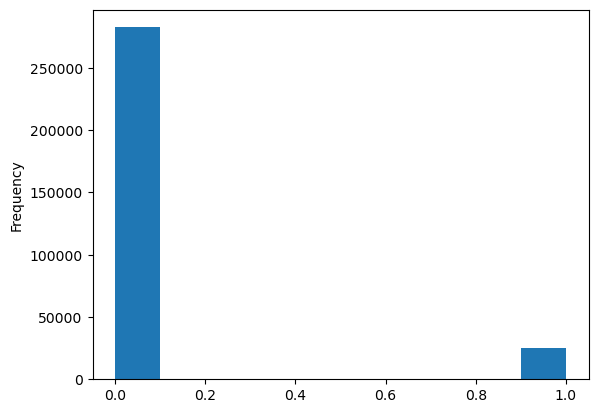

In [14]:
app_train['TARGET'].astype(int).plot.hist();

Terlihat adanya *imbalance data*, dimana pinjaman yang dilunasi tepat waktu jauh lebih banyak dibanding pinjaman yang tidak dilunasi. 

#### **Check Missing Value**

In [15]:
# calculate missing value
def missing_values_table(df):
    
    # total missing value
    mis_val = df.isnull().sum()
    
    # persentase missing value
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # membuat tabel dengan hasilnya
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # rename kolom
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # urutkan tabel berdasarkan persentase yang hilang secara descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
    # cetak beberapa summary
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    # return dataframe dengan missing value
    return mis_val_table_ren_columns

In [16]:
# missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Pada model machine learning akan digunakan model seperti XGBoost yang dapat menangani nilai yang hilang tanpa memerlukan imputation. Atau menghapus kolom dengan nilai missing value yang tinggi.

#### **Tipe Kolom**

In [17]:
# jumlah setiap jenis kolom
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [18]:
# jumlah nilai unik di setiap kolom object
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Sebagian besar variabel kategori memiliki jumlah nilai unik yang kecil, sehingga perlu cara untuk menangani variabel kategori ini.

In [19]:
app_train['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

#### **Encoding Variabel Kategorik**

In [20]:
# membuat label encoding
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        
        # jika 2 atau kurang kategori unik
        if len(list(app_train[col].unique())) <= 2:
            
            # train data pelatihan
            le.fit(app_train[col])
            
            # transformasikan data pelatihan dan pengujian
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # melacak berapa banyak kolom yang diberi label encoding
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [21]:
# one-hot encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


##### **Menyelaraskan Data Training dan Data Testing**

**Menyelaraskan Data Training dan Data Testing**

In [22]:
train_labels = app_train['TARGET']

# sejajarkan data training dan data testing, hanya pertahankan kolom yang ada di kedua dataframe
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# tambahkan target kembali
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


#### **Back to EDA**

Angka pada kolom DAYS_BIRTH bernilai negatif karena dicatat relatif terhadap pengajuan pinjaman saat ini. Untuk melihat statistik ini dalam tahun, kita dapat mengalikannya dengan -1 dan membaginya dengan jumlah hari dalam setahun. 

In [23]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Nilai usia masuk akal dan tidak ada perbedaan usia yang signifikan.

In [24]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Jumlah hari kerja cukup aneh karena terdapat nilai negatif dan nilai positifnya mencapai ribuan tahun.

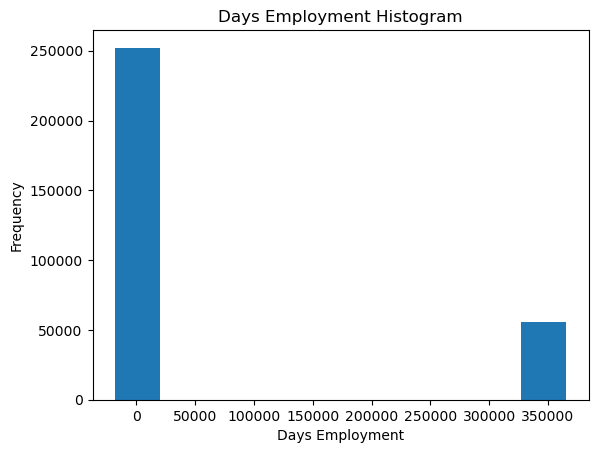

In [25]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Mengelompokkan klien-klien yang anomali tersebut dan lihat apakah mereka memiliki tingkat gagal bayar yang tinggi atau rendah dibandingkan klien lainnya. 

In [26]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Ternyata anomali memiliki tingkat gagal bayar yang lebih rendah. 

Penanganan anomali bergantung pada situasi sebenarnya, tanpa aturan yang ditetapkan. Salah satu pendekatan teraman adalah dengan menyetel anomali ke nilai yang hilang dan kemudian mengisinya (menggunakan Imputasi) sebelum pembelajaran mesin. Dalam hal ini, karena semua anomali memiliki nilai yang sama persis, kami ingin mengisinya dengan nilai yang sama seandainya semua pinjaman ini memiliki kesamaan. Nilai-nilai anomali tampaknya memiliki arti penting, jadi kami ingin memberi tahu model pembelajaran mesin apakah kami benar-benar mengisi nilai-nilai ini. Sebagai solusinya, kita akan mengisi nilai anomali tersebut dengan bukan angka (np.nan) lalu membuat kolom boolean baru yang menunjukkan apakah nilai tersebut anomali atau tidak.

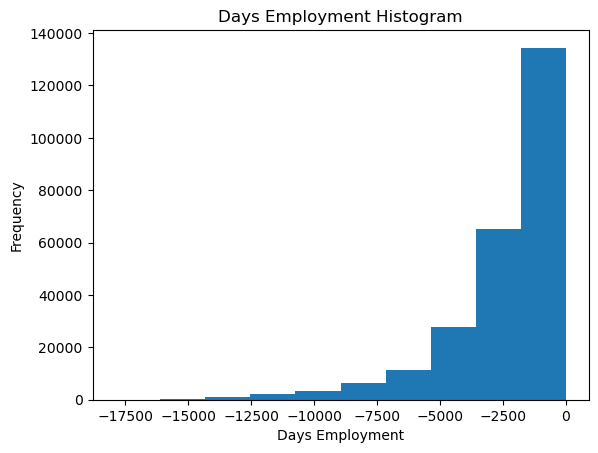

In [27]:
# buat kolom flag anomali
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Rganti nilai anomali dengan nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Distribusinya terlihat lebih sesuai dengan apa yang diharapkan. 

Sebagai catatan yang sangat penting, apa pun yang dilakukan terhadap data training juga harus dilakukan pada data testing. Pastikan untuk membuat kolom baru dan mengisi kolom yang ada dengan np.nan di data testing.

In [28]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


##### **Korelasi**

- .00-.19 = “very weak”
- .20-.39 = “weak”
- .40-.59 = “moderate”
- .60-.79 = “strong”
- .80-1.0 = “very strong”

In [29]:
# menemukan korelasi dengan target dan mengurutkannya
correlations = app_train.corr()['TARGET'].sort_values()

# display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

DAYS_BIRTH adalah korelasi yang paling positif. (kecuali TARGET karena korelasi suatu variabel dengan variabel itu sendiri selalu 1!). DAYS_BIRTH adalah usia klien dalam hari pada saat pinjaman di hari negatif (apa pun alasannya!). Korelasinya positif, namun nilai fitur ini sebenarnya negatif, artinya seiring bertambahnya usia nasabah, kecil kemungkinannya untuk gagal bayar (yaitu target == 0). Karena sedikit membingungkan, maka akan diambil nilai absolut dari fitur tersebut dan korelasinya akan menjadi negatif.

##### **Pengaruh Age terhadap Repayment (pelunasan)**

In [30]:
# temukan korelasi dari positive days sejak birth dan target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982745

Terdapat hubungan linier negatif dengan target yang berarti seiring bertambahnya usia nasabah, mereka cenderung lebih sering membayar kembali pinjamannya tepat waktu.

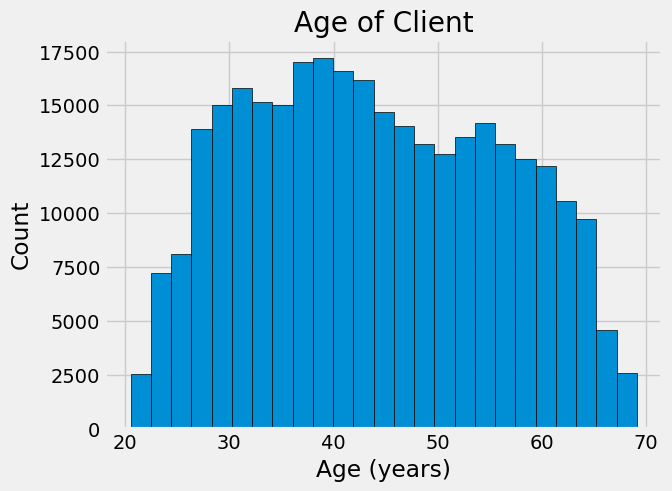

In [31]:
# set the style of plots
plt.style.use('fivethirtyeight')

# plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

Seluruh usia masuk akal dan tidak ada outliers. Untuk memvisualisasikan pengaruh umur terhadap target, akan dibuat plot KDE.

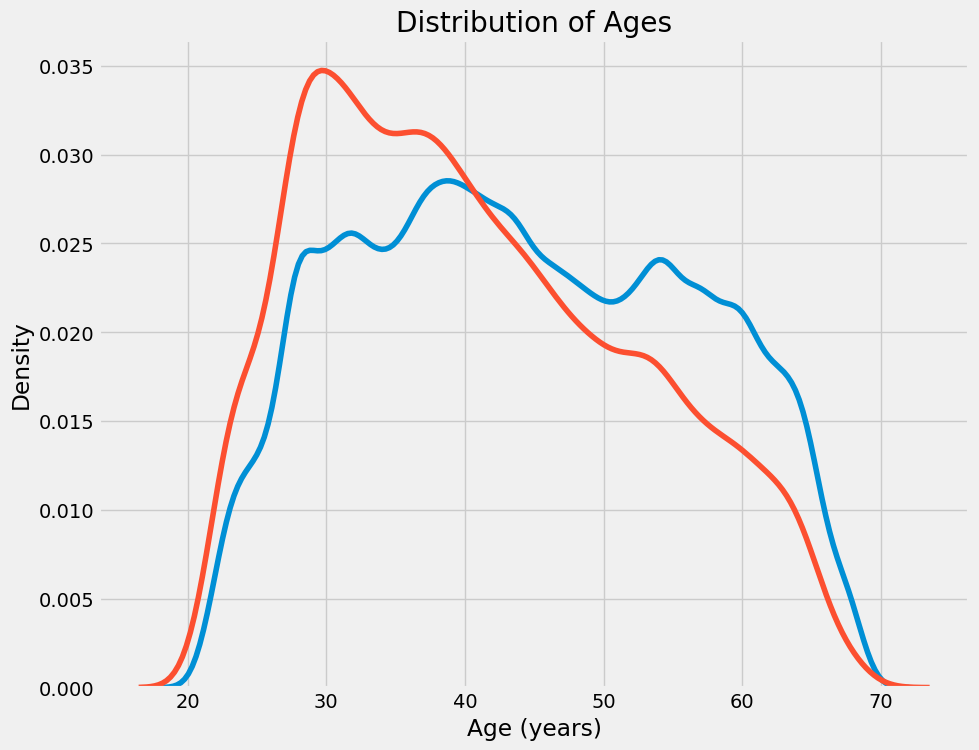

In [32]:
plt.figure(figsize = (10, 8))

# KDE plot yang melunasi tepat waktu
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot yang tidak dilunasi tepat waktu
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# labeling plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Kurva target == 1 condong ke arah ujung rentang yang lebih muda. Meskipun korelasinya tidak signifikan (koefisien korelasi -0,07), variabel ini kemungkinan besar akan berguna dalam model machine learning karena mempengaruhi target. <br>

Selanjutnya, melihat hubungan ini dengan cara lain seperti rata-rata kegagalan membayar kembali pinjaman berdasarkan kelompok usia.

In [33]:
# age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# masukkan data usia
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [34]:
# kelompokkan berdasarkan bin dan hitung rata-ratanya
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


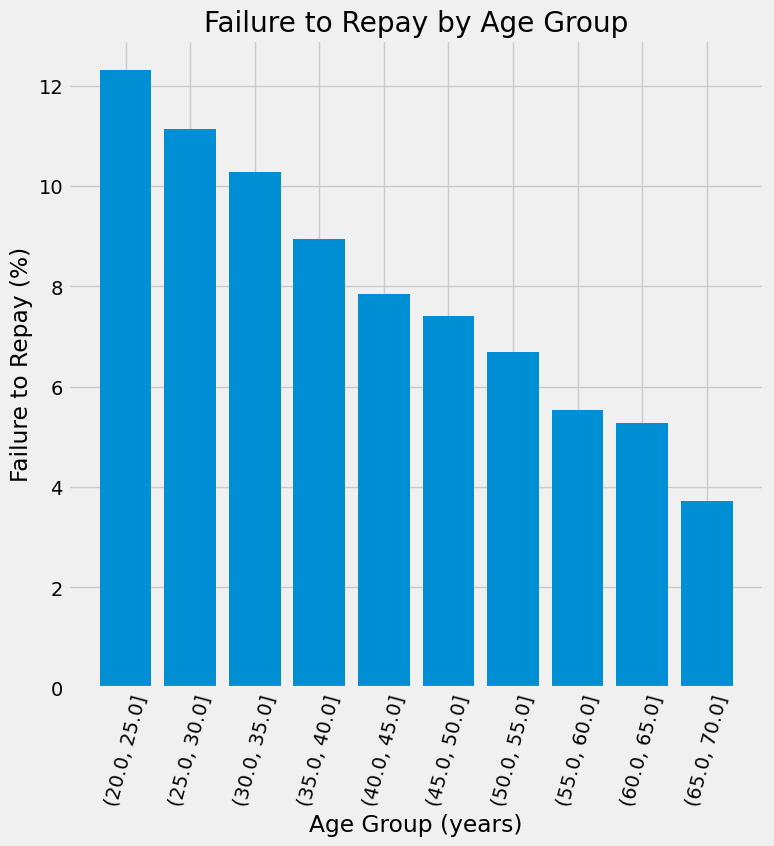

In [35]:
plt.figure(figsize = (8, 8))

# buat grafik rentang usia dan rata-rata target dalam bentuk diagram batang
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Ada tren yang jelas: pemohon yang lebih muda cenderung tidak membayar kembali pinjamannya! Tingkat kegagalan membayar di atas 10% untuk tiga kelompok umur termuda dan di bawah 5% untuk kelompok umur tertua.

Ini adalah informasi yang dapat langsung digunakan oleh bank: karena nasabah yang lebih muda cenderung tidak dapat membayar kembali pinjamannya, mungkin mereka harus diberikan lebih banyak panduan atau tip perencanaan keuangan. Hal ini tidak berarti bank harus melakukan diskriminasi terhadap nasabah muda, namun akan lebih bijaksana jika bank mengambil tindakan pencegahan untuk membantu nasabah muda membayar tepat waktu.

##### **Exterior Sources**

3 variabel yang memiliki korelasi negatif paling kuat dengan target adalah EXT_SOURCE_1, EXT_SOURCE_2, dan EXT_SOURCE_3. Menurut dokumentasi, fitur-fitur ini mewakili "skor yang dinormalisasi dari sumber data eksternal". Saya tidak yakin apa arti sebenarnya dari hal ini, tetapi ini mungkin merupakan peringkat kredit kumulatif yang dibuat menggunakan berbagai sumber data.

Pertama, kita dapat menunjukkan korelasi fitur EXT_SOURCE dengan target dan satu sama lain.

In [36]:
# ekstrak variabel EXT_SOURCE dan tunjukkan korelasinya
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


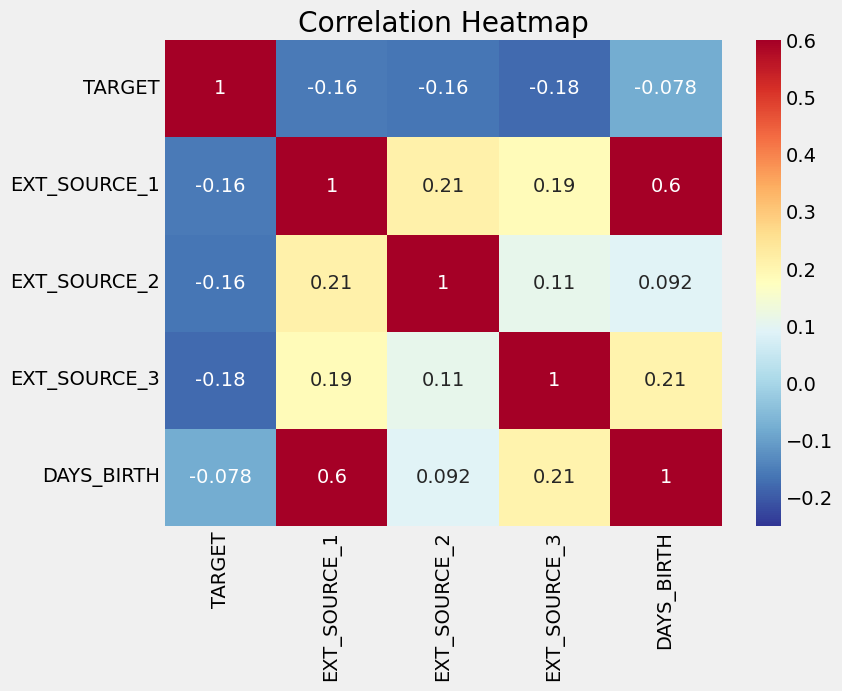

In [37]:
plt.figure(figsize = (8, 6))

# heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Ketiga fitur EXT_SOURCE memiliki korelasi negatif dengan target, yang menunjukkan bahwa seiring dengan peningkatan nilai EXT_SOURCE, kemungkinan besar klien akan membayar kembali pinjamannya. Kita juga dapat melihat bahwa DAYS_BIRTH berkorelasi positif dengan EXT_SOURCE_1 yang menunjukkan bahwa mungkin salah satu faktor dalam skor ini adalah usia klien.

Selanjutnya kita bisa melihat sebaran masing-masing fitur tersebut diwarnai oleh nilai targetnya. Ini akan memungkinkan kita memvisualisasikan pengaruh variabel ini terhadap target.

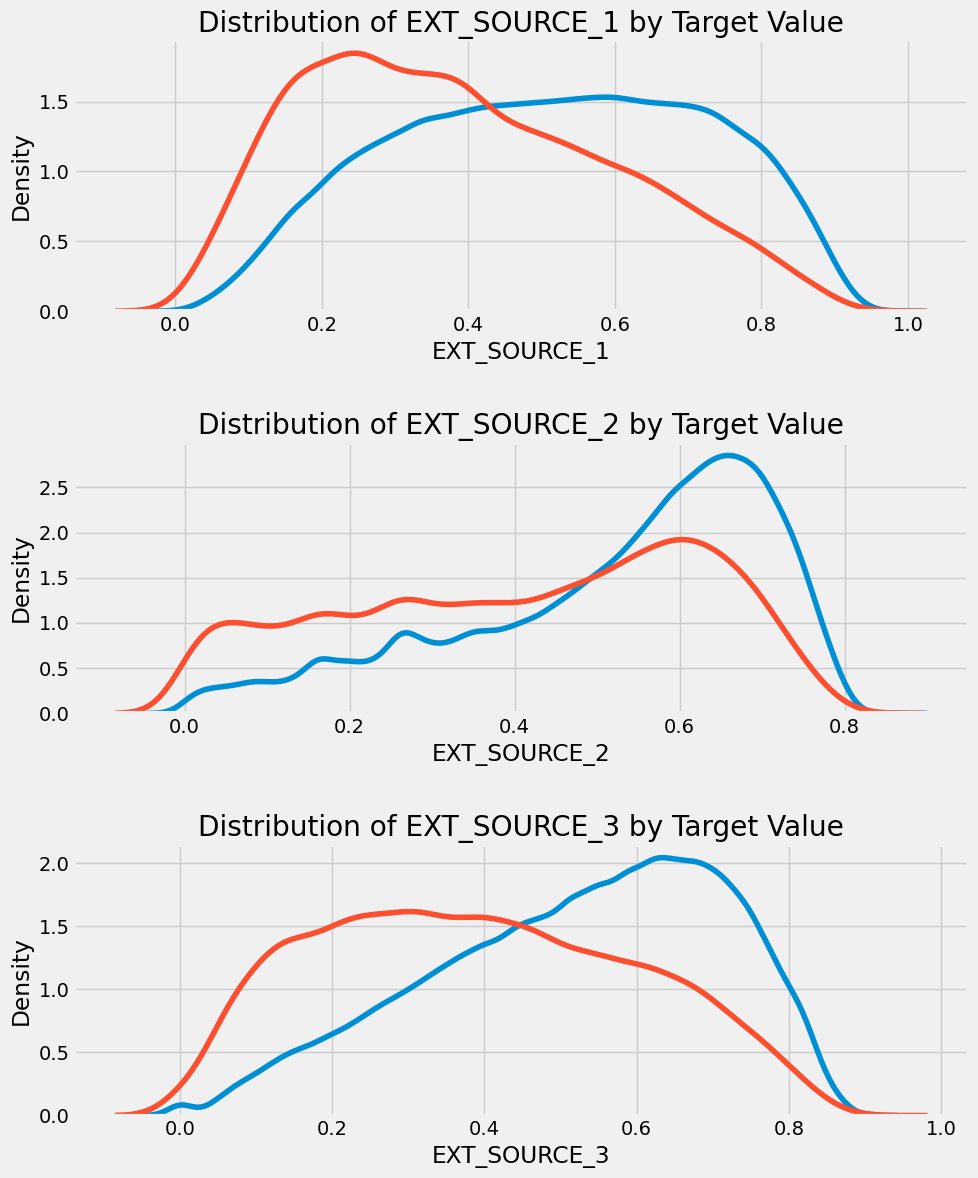

In [38]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # buat subplot baru untuk setiap sumber
    plt.subplot(3, 1, i + 1)
    
    # plot pinjaman yang dilunasi
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    
    # plot pinjaman yang gagal dilunasi
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')

    # label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 menampilkan perbedaan terbesar antara nilai target. Kita dapat melihat dengan jelas bahwa fitur ini ada hubungannya dengan kemungkinan pemohon membayar kembali pinjamannya. Hubungannya tidak terlalu kuat (bahkan semuanya dianggap sangat lemah, namun variabel-variabel ini tetap berguna bagi model pembelajaran mesin untuk memprediksi apakah pemohon akan membayar kembali pinjamannya tepat waktu atau tidak.

#### **Feature Engineering**

In [39]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [40]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

##### **Visualisasi Variabel Baru**

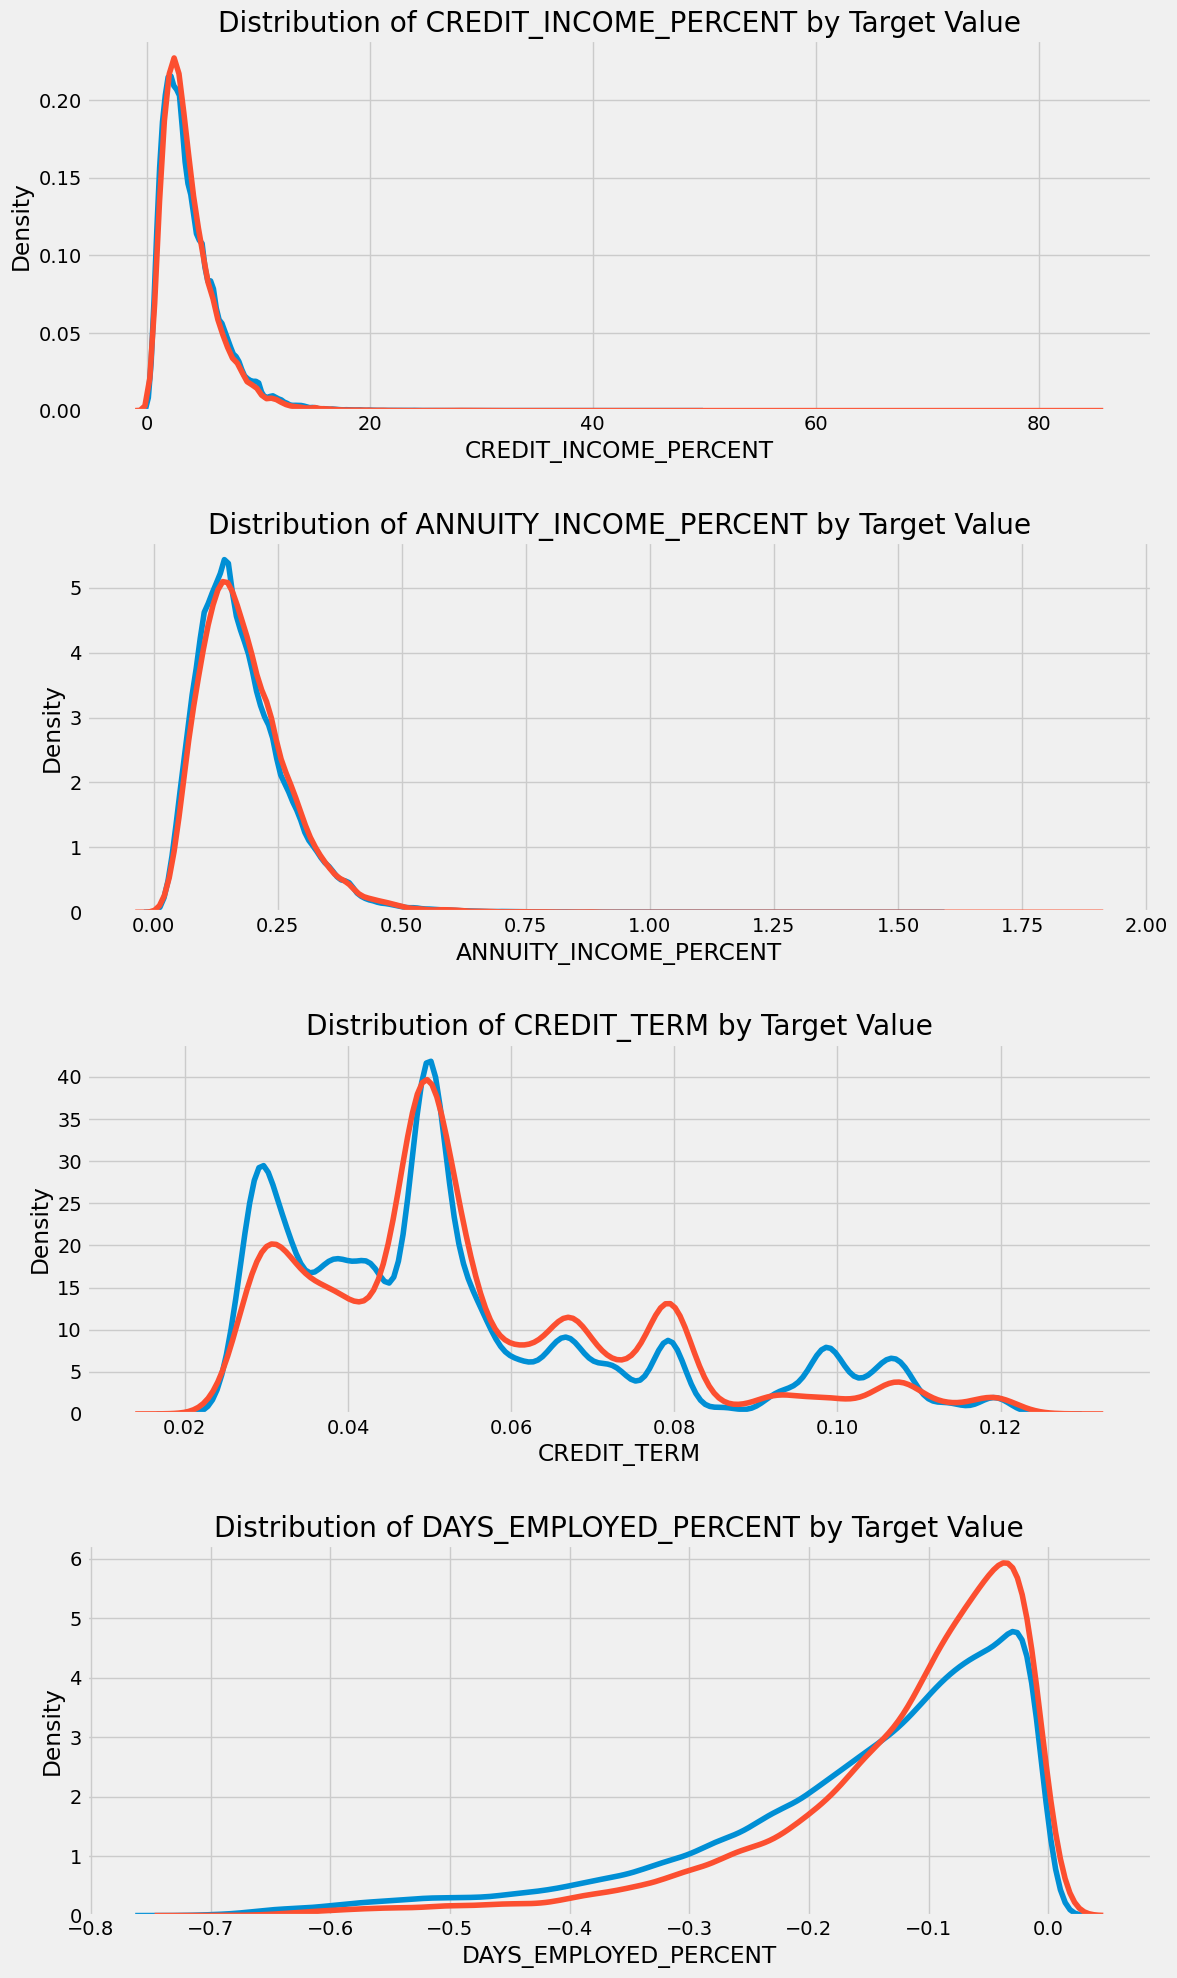

In [42]:
plt.figure(figsize = (12, 20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # buat subplot baru untuk setiap source
    plt.subplot(4, 1, i + 1)
    
    # plot pinjaman yang dilunasi
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    
    # plot pinjaman yang tidak dilunasi
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

#### **Baseline**

**Logistic Regression**

In [46]:
# # Drop the target from the training data
# if 'TARGET' in app_train:
#     train = app_train.drop(columns = ['TARGET'])
# else:
#     train = app_train.copy()
app_train2 = app_train.dropna()
train = app_train2.drop(columns=['TARGET'])
label = app_train2['TARGET']

x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.25, random_state=2023)

In [47]:
# buat model dengan parameter regularisasi yang ditentukan
log_reg = RandomForestClassifier(random_state=42, max_depth=3, class_weight="balanced")

# latih data training
log_reg.fit(x_train, y_train)

# buat prediksi
# pastikan untuk memilih kolom kedua saja
log_reg_pred = log_reg.predict_proba(x_test)[:, 1]
log_reg_pred_train = log_reg.predict_proba(x_train)[:, 1]

print(roc_auc_score(y_test, log_reg_pred))
print(roc_auc_score(y_train, log_reg_pred_train))

0.6937363368501094
0.7792321526311674


In [48]:
# extract feature importances
feature_importance_values = log_reg.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

NameError: name 'features' is not defined

In [52]:
# buat model dengan parameter regularisasi yang ditentukan
log_reg2 = LogisticRegression(random_state=42)

# latih data training
log_reg2.fit(x_train, y_train)

# buat prediksi
# pastikan untuk memilih kolom kedua saja
log_reg_pred2 = log_reg2.predict_proba(x_test)[:, 1]
log_reg_pred_train2 = log_reg2.predict_proba(x_train)[:, 1]

print(roc_auc_score(y_test, log_reg_pred2))
print(roc_auc_score(y_train, log_reg_pred_train2))

0.6016609637867122
0.6139427471345256


In [54]:
train = app_train.drop(columns=['TARGET'])
label = app_train['TARGET']

x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.25)

# nama fitur
features = list(train.columns)

# copy data testing
test = app_test.copy()

# imputasi median dari missing values
imputer = SimpleImputer(strategy = 'median')

# skala setiap fitur ke 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# fit on the training data
imputer.fit(x_train)

# transformasi data training dan data testing
x_train = imputer.transform(x_train)
x_test = imputer.transform(x_test)

# ulangi dengan scaler
scaler.fit(x_train)
train = scaler.transform(x_train)
test = scaler.transform(x_test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (230633, 240)
Testing data shape:  (76878, 240)


In [ ]:
# Logistic Regression

In [55]:
# buat model dengan parameter regularisasi yang ditentukan
log_reg = LogisticRegression(C = 0.0001)

# latih data training
log_reg.fit(train, y_train)

LogisticRegression(C=0.0001)

In [57]:
# make predictions
# make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

print(roc_auc_score(y_test, log_reg_pred))

0.6826276060366105


##### **Improved Model: Random Forest**

In [58]:
# make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [59]:
# train on the training data
random_forest.fit(train, y_train)

# extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [60]:
print(roc_auc_score(y_test, predictions))

0.7085642455515444


##### **Model Interpretation: Feature Importances**

In [64]:
def plot_feature_importances(df):
    
   # urutkan fitur berdasarkan kepentingannya
    df = df.sort_values('importance', ascending = False).reset_index()

    # normalisasikan kepentingan fitur untuk menambahkan hingga satu
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # buat barchart untuk feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # membalik indeks untuk menempatkan yang paling penting diatas
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df 

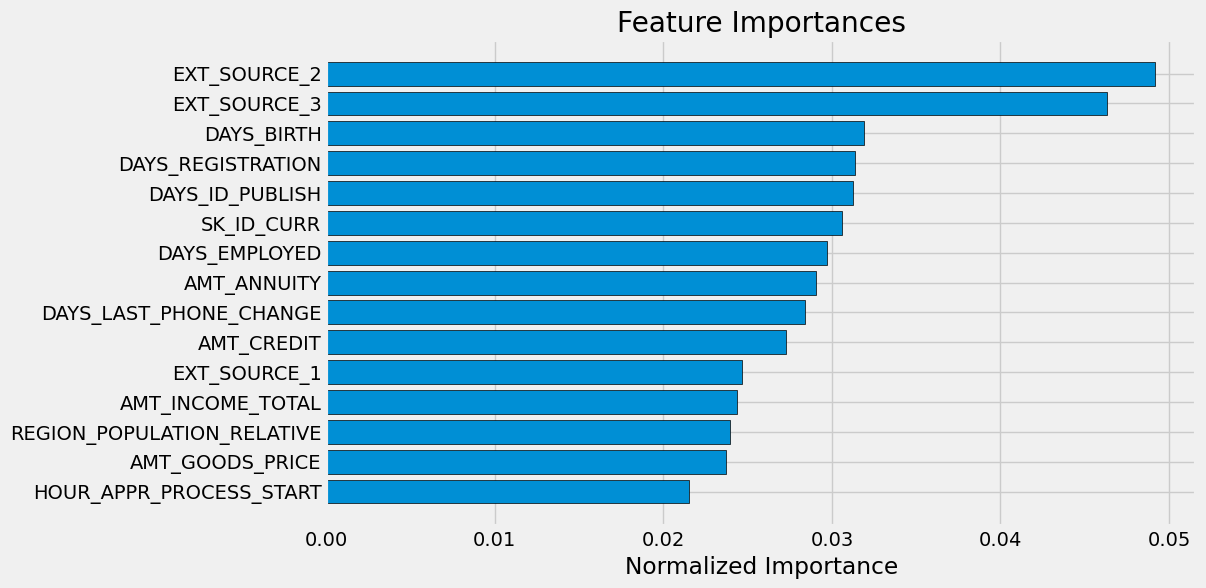

In [65]:
# menampilkan fitur importance
feature_importances_sorted = plot_feature_importances(feature_importances)